# <center> <머신러닝 기말 프로젝트> <br> Machine Learning을 활용한 기후 및 토양 환경요인 기반 작물 추천 및 예측 모델 개발</center>



---



- <h3> 제목 : 기후와 토양환경을 기반으로 한 작물 추천 프로그램<br>
- <h3> 목적 : 농업 생산량의 증진을 위해 각 환경 요인에 맞는 적절한 작물을 추천함으로서 더 나은 선택을 할 수 있도록 도움을 줌<br>
- <h3> 요약 : 알고리즘을 활용하여 종류별로 작물이 자라는 환경 데이터를 train 데이터와 test 데이터로 나눠 학습한다. 이후 학습된 모델을 바탕으로 작물 추천 프로그램을 실행하여 해당 환경 요소 값을 입력하면 그 환경에 최적인 적절한 작물이 추천된다.

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
df=pd.read_csv('C:\ml_res/Crop01.csv')
df.head()

,N,P,K,temperature,humidity,ph,rainfall,label
0,90,42,43,20.879744,82.002744,6.502985,202.935536,rice
1,85,58,41,21.770462,80.319644,7.038096,226.655537,rice
2,60,55,44,23.004459,82.320763,7.840207,263.964248,rice
3,74,35,40,26.491096,80.158363,6.980401,242.864034,rice
4,78,42,42,20.130175,81.604873,7.628473,262.717340,rice


In [ ]:
df.describe()

,N,P,K,temperature,humidity,ph,rainfall
count,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000
mean,50.551818,53.362727,48.149091,25.616244,71.481779,6.469480,103.463655
std,36.917334,32.985883,50.647931,5.063749,22.263812,0.773938,54.958389
min,0.000000,5.000000,5.000000,8.825675,14.258040,3.504752,20.211267
25%,21.000000,28.000000,20.000000,22.769375,60.261953,5.971693,64.551686
50%,37.000000,51.000000,32.000000,25.598693,80.473146,6.425045,94.867624
75%,84.250000,68.000000,49.000000,28.561654,89.948771,6.923643,124.267508
max,140.000000,145.000000,205.000000,43.675493,99.981876,9.935091,298.560117


# 데이터셋 EDA

### null/누락된 값을 확인 (히트맵 사용)

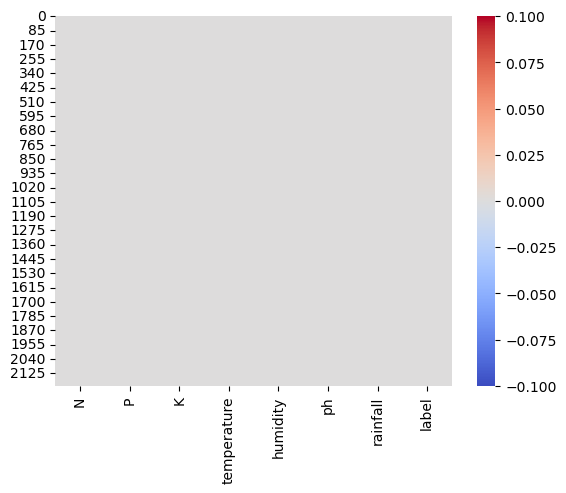

In [ ]:
sns.heatmap(df.isnull(),cmap="coolwarm")
plt.show()

<h4> <u>온도와 pH의 분포 살펴보기</u><br><br>
    
두 데이터는 정규분포 형태를 보이며, 상관관계가 있음을 알 수 있음</h4>

<Axes: xlabel='ph', ylabel='Density'>

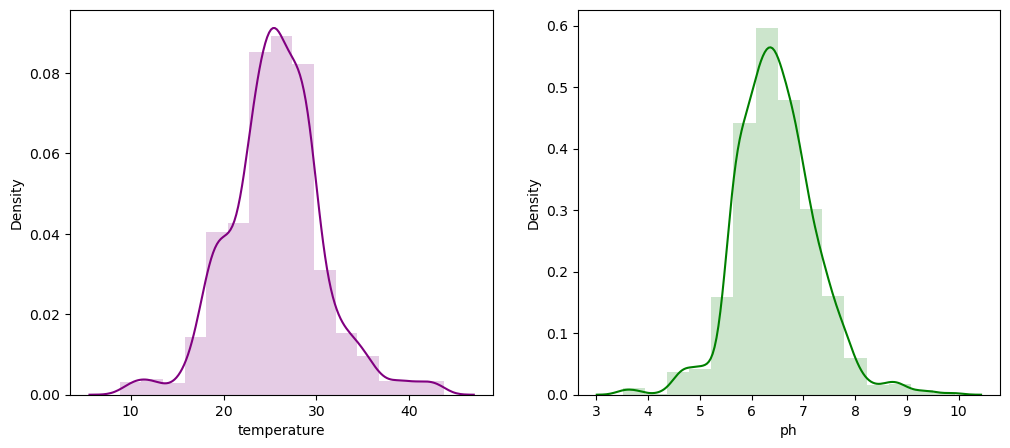

In [ ]:
plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
# sns.distplot(df_setosa['sepal_length'],kde=True,color='green',bins=20,hist_kws={'alpha':0.3})
sns.distplot(df['temperature'],color="purple",bins=15,hist_kws={'alpha':0.2})
plt.subplot(1, 2, 2)
sns.distplot(df['ph'],color="green",bins=15,hist_kws={'alpha':0.2})

<h4> 데이터셋 불균형 확인하기 -> 데이터셋이 불균형 하면 다운 샘플링이 필요하지만, 해당 데이터셋은 잘 균형이 잡혀있다 <h4>

<Axes: xlabel='count', ylabel='label'>

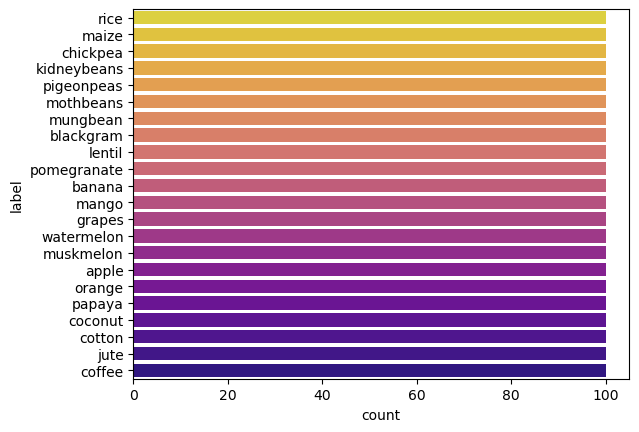

In [ ]:
sns.countplot(y='label',data=df, palette="plasma_r")

<h4>두 Feature 간 상관관계를 Diagonal plot를 활용하여 확인하기

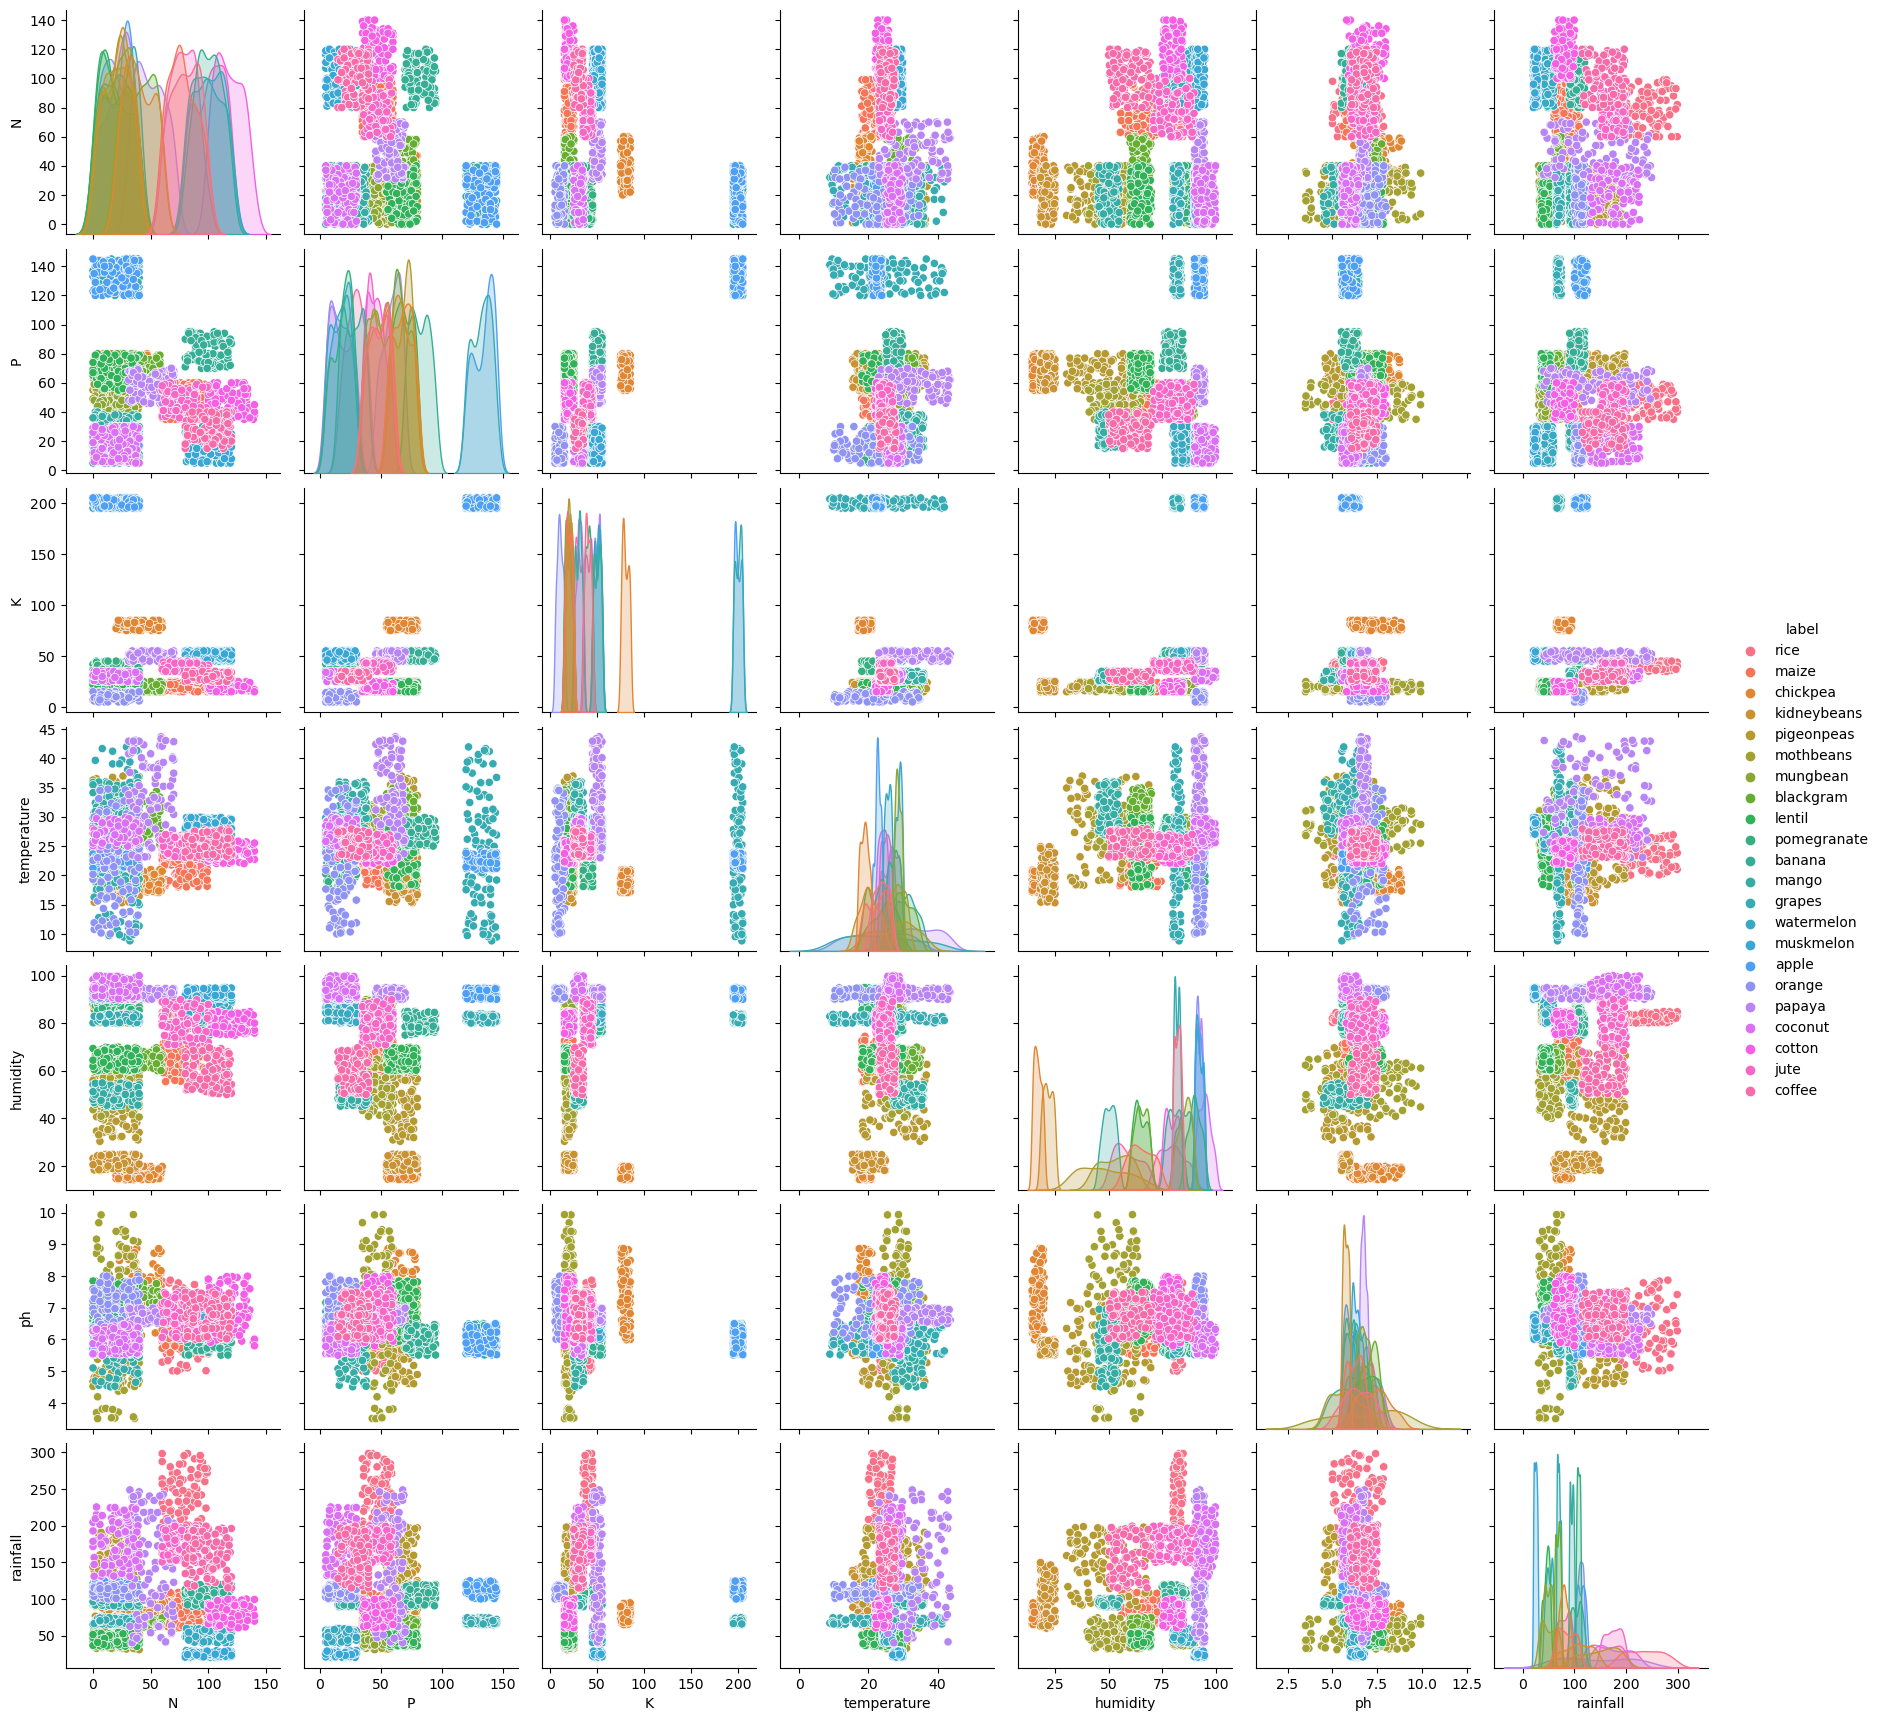

In [ ]:
sns.pairplot(df, hue = 'label')

#### 장마철에는 평균 강수량이 높고(평균 120mm), 기온은 약간 낮음 (30°C 미만)

#### 비는 토양의 수분을 영향을 주며, 이는 토양의 pH에 영향을 미친다.

- <b>  벼는 많은 강수량 (>200 mm)과 80% 이상의 높은 습도가 필요
- <b> 코코넛은 열대 작물로 높은 습도가 필요


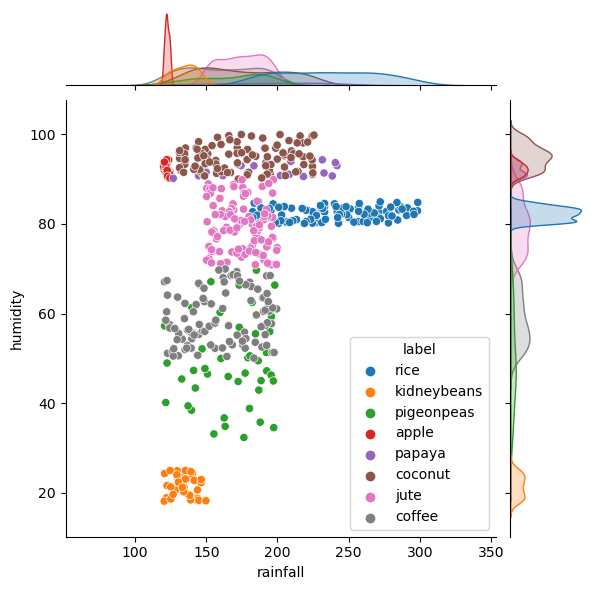

In [ ]:
sns.jointplot(x="rainfall",y="humidity",data=df[(df['temperature']<30) & (df['rainfall']>120)],hue="label")

#### This graph correlates with average potassium (K) and average nitrogen (N) value (both>50).
#### These soil ingredients direcly affects nutrition value of the food. Fruits which have high nutrients typically has consistent potassium values.

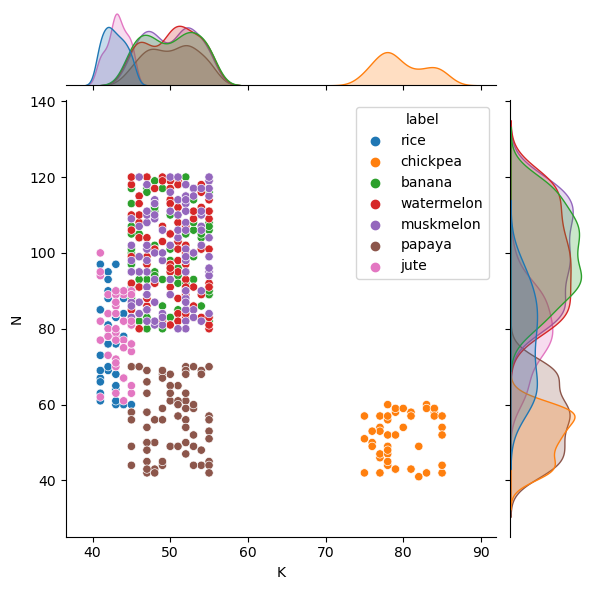

In [ ]:
sns.jointplot(x="K",y="N",data=df[(df['N']>40)&(df['K']>40)],hue="label")

:<h4>습도와 K (토양의 칼륨 Level) 사이의 특정 케이스에 대한 plot 그리기</h4>

#### sns.jointplot()은 Label 유형에 기반하여 습도와 칼륨(K) 수준 사이의 이변량 분석을 위한 플롯을 생성하는 데 사용될 수 있다. 또한, 특성에 대한 클래스의 빈도 분포를 추가로 생성한다.

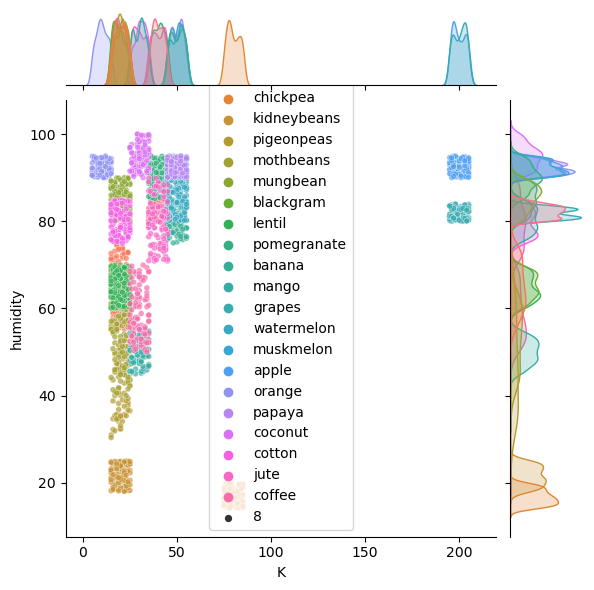

In [ ]:
sns.jointplot(x="K",y="humidity",data=df,hue='label',size=8,s=30,alpha=0.7)

#### We can see ph values are critical when it comes to soil. A stability between 6 and 7 is preffered

<Axes: xlabel='ph', ylabel='label'>

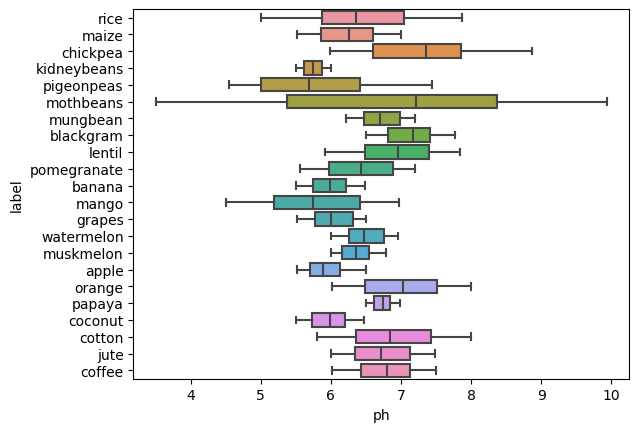

In [ ]:
sns.boxplot(y='label',x='ph',data=df)

#### 비가 많이 올 때 (150mm 이상) Phosphorous(인산염) Level 차이가 있음

<Axes: xlabel='P', ylabel='label'>

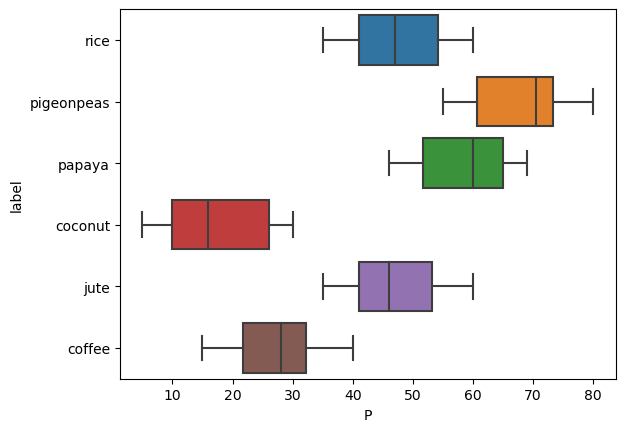

In [ ]:
sns.boxplot(y='label',x='P',data=df[df['rainfall']>150])

#### phosphorous level 분석

습도가 65 미만일 때, 향후 몇 주 동안 예상되는 비의 양에 따라 재배될 수 있는 6가지 작물에 대해 거의 동일한 phosphorous level(약 14에서 25 사이)이 필요하다

<Axes: xlabel='K', ylabel='rainfall'>

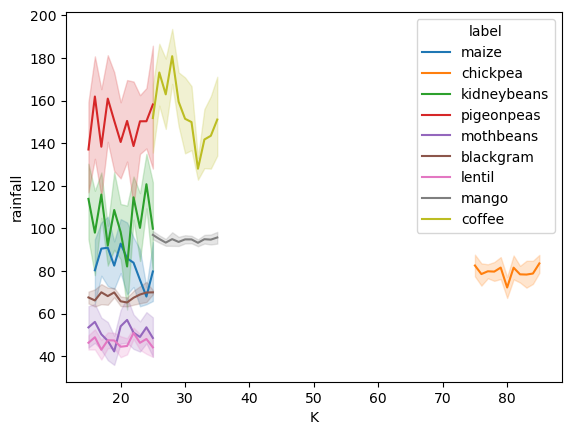

In [ ]:
sns.lineplot(data = df[(df['humidity']<65)], x = "K", y = "rainfall",hue="label")

# 데이터 전처리


In [ ]:
c=df.label.astype('category')
targets = dict(enumerate(c.cat.categories))
df['target']=c.cat.codes

y=df.target
X=df[['N','P','K','temperature','humidity','ph','rainfall']]

**Feature 간의 상관관계 시각화. Phosphorous Level과 칼륨(K) Level이 매우 높게 상관되어 있음을 볼 수 있음.**

<Axes: >

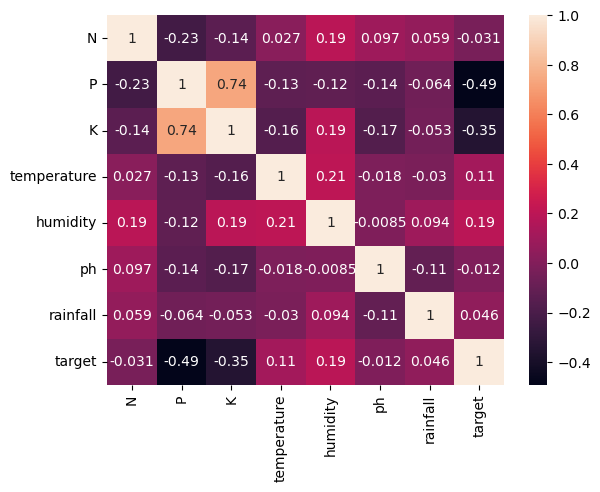

In [ ]:
sns.heatmap(df.corr(),annot=True)

# FEATURE 스케일링
**모델에 훈련 데이터를 생성하고 입력하기 전에 특성 스케일링이 필요함.**

두 특성(온도와 pH)은 가우시안 분포를 따름 -> 따라서 이들을 MinMaxScaler를 사용하여 0과 1 사이로 스케일링

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size = 0.3,random_state =2)

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)

# we must apply the scaling to the test set as well that we are computing for the training set
X_test_scaled = scaler.transform(X_test)

# 모델 선택하기

## KNN Classifier for Crop prediction.
<hr>

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knn.fit(X_train_scaled, y_train)
knn.score(X_test_scaled, y_test)

0.9803030303030303

### Confusion Matrix

<Axes: >

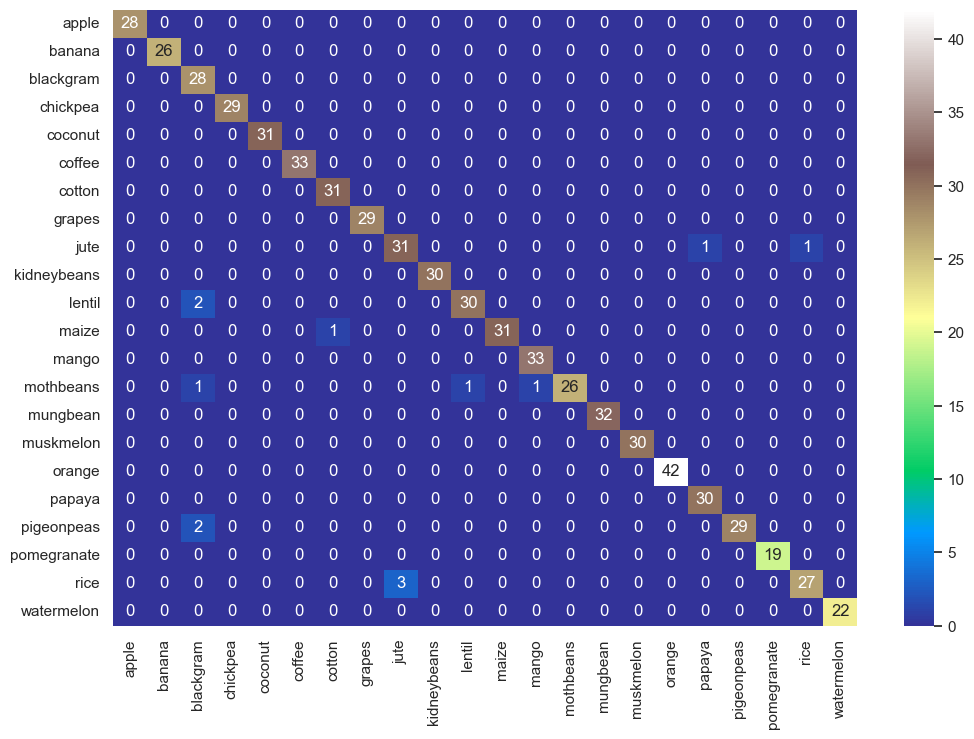

In [ ]:
from sklearn.metrics import confusion_matrix
mat=confusion_matrix(y_test,knn.predict(X_test_scaled))
df_cm = pd.DataFrame(mat, list(targets.values()), list(targets.values()))
sns.set(font_scale=1.0) # for label size
plt.figure(figsize = (12,8))
sns.heatmap(df_cm, annot=True, annot_kws={"size": 12},cmap="terrain")

### <div style="color:blue;"><b> Classification report of KNN</b></div>

#### **분류 보고서를 위해 <u>yellowbrick</u>을 사용**

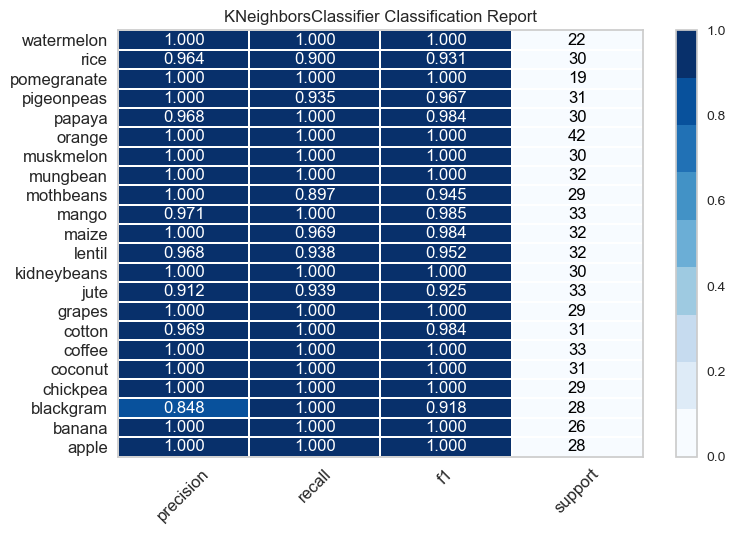

<Axes: title={'center': 'KNeighborsClassifier Classification Report'}>

In [ ]:
from yellowbrick.classifier import ClassificationReport
classes=list(targets.values())
visualizer = ClassificationReport(knn, classes=classes, support=True,cmap="Blues")

visualizer.fit(X_train_scaled, y_train)  # Fit the visualizer and the model
visualizer.score(X_test_scaled, y_test)  # Evaluate the model on the test data
visualizer.show()

### n_neighbors의 다양한 값으로 세밀하게 조정

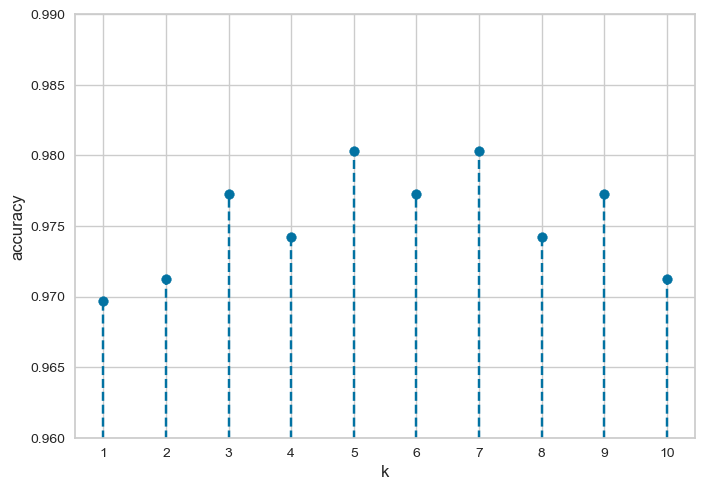

In [ ]:
k_range = range(1,11)
scores = []

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(X_train_scaled, y_train)
    scores.append(knn.score(X_test_scaled, y_test))

plt.xlabel('k')
plt.ylabel('accuracy')
plt.scatter(k_range, scores)
plt.vlines(k_range,0, scores, linestyle="dashed")
plt.ylim(0.96,0.99)
plt.xticks([i for i in range(1,11)]);

## Support Vector Classifier(SVC)를 사용한 분류
<hr>

In [ ]:
from sklearn.svm import SVC

svc_linear = SVC(kernel = 'linear').fit(X_train_scaled, y_train)
print("Linear Kernel Accuracy: ",svc_linear.score(X_test_scaled,y_test))

svc_poly = SVC(kernel = 'rbf').fit(X_train_scaled, y_train)
print("Rbf Kernel Accuracy: ", svc_poly.score(X_test_scaled,y_test))

svc_poly = SVC(kernel = 'poly').fit(X_train_scaled, y_train)
print("Poly Kernel Accuracy: ", svc_poly.score(X_test_scaled,y_test))

Linear Kernel Accuracy:  0.9666666666666667
Rbf Kernel Accuracy:  0.9848484848484849
Poly Kernel Accuracy:  0.9833333333333333


### 매개변수 튜닝으로 SVC 선형 모델의 정확도 높이기

**GridSearchCV는 최적의 매개변수를 찾는 데 도움을 줄 수 있음**

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

parameters = {'C': np.logspace(-3, 2, 6).tolist(), 'gamma': np.logspace(-3, 2, 6).tolist()}
# 'degree': np.arange(0,5,1).tolist(), 'kernel':['linear','rbf','poly']

model = GridSearchCV(estimator = SVC(kernel="linear"), param_grid=parameters, n_jobs=-1, cv=4)
model.fit(X_train, y_train)

GridSearchCV(cv=4, estimator=SVC(kernel='linear'), n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0],
                         'gamma': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]})

In [ ]:
print(model.best_score_ )
print(model.best_params_ )

0.987012987012987
{'C': 1.0, 'gamma': 0.001}


**POINTS TO BE HIGHLIGHTED**
1. liner kernel도 결과가 나쁘지 않지만, fine tuning은 계산을 증가시키고 일부 case에 비효율적일 수 있음
2. 파라미터를 조정함으로써 다항 커널의 정확도를 높일 수 있지만, 과적합을 초래할 수 있음
3. RBF는 선형 커널보다 더 좋은 결과를 보임
4. 지금까지 Poly kernel이 small margin으로 가장 좋은 성과를 보임

## Decision tree로 분류
<hr>

In [ ]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(random_state=42).fit(X_train, y_train)
clf.score(X_test,y_test)

0.9833333333333333

결정 트리 중요한 특성들을 시각화 하기



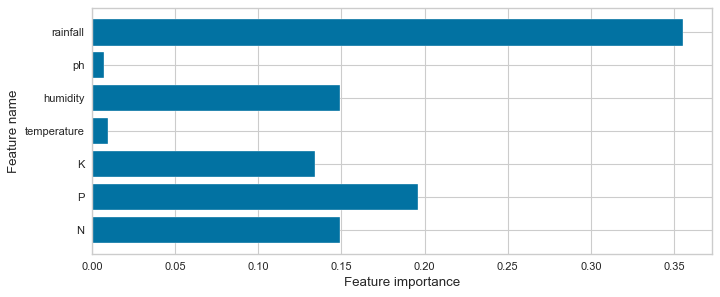

In [ ]:
plt.figure(figsize=(10,4), dpi=80)
c_features = len(X_train.columns)
plt.barh(range(c_features), clf.feature_importances_)
plt.xlabel("Feature importance")
plt.ylabel("Feature name")
plt.yticks(np.arange(c_features), X_train.columns)
plt.show()

## Random Forest을 사용한 분류
<hr>

In [ ]:
'''
max depth and n_estimator are important to fine tune otherwise trees will be densely graphed which will be a classic case of overfitting. max_depth=4 and n_estimators=10 gives pretty much satisfying results by making sure model is able to generalize well.
'''

from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(max_depth=4,n_estimators=100,random_state=42).fit(X_train, y_train)

print('RF Accuracy on training set: {:.2f}'.format(clf.score(X_train, y_train)))
print('RF Accuracy on test set: {:.2f}'.format(clf.score(X_test, y_test)))

RF Accuracy on training set: 0.95
RF Accuracy on test set: 0.94


<Axes: >

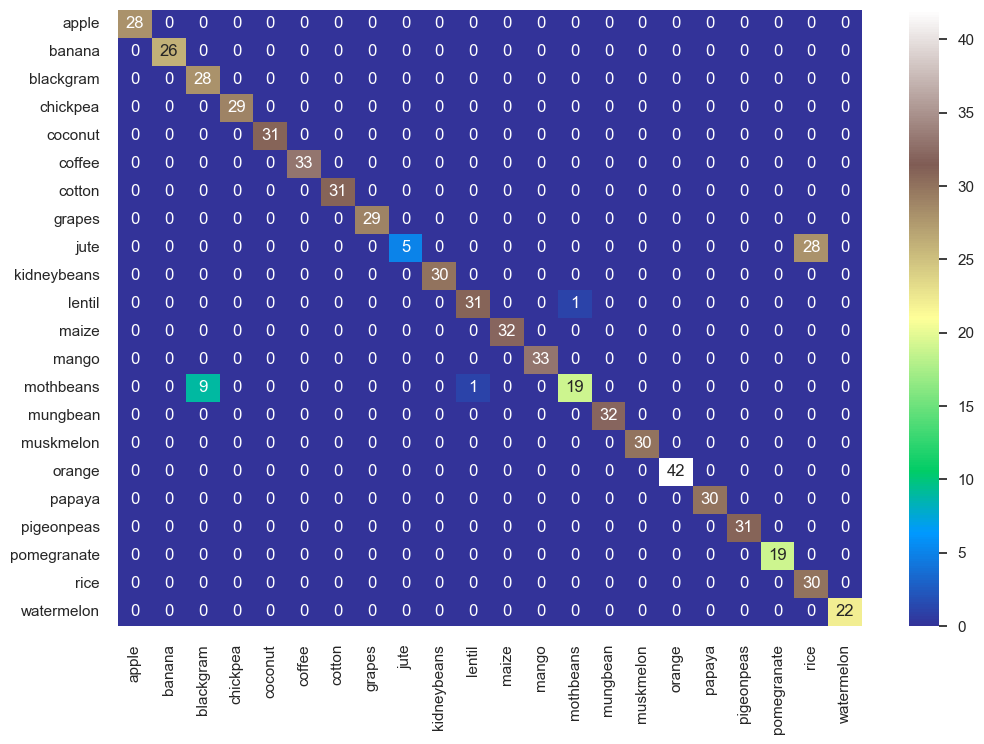

In [ ]:
from sklearn.metrics import confusion_matrix
mat=confusion_matrix(y_test,clf.predict(X_test))
df_cm = pd.DataFrame(mat, list(targets.values()), list(targets.values()))
sns.set(font_scale=1.0) # for label size
plt.figure(figsize = (12,8))
sns.heatmap(df_cm, annot=True, annot_kws={"size": 12},cmap="terrain")

### <div style="color:blue;"><b> Classification report of Random Forest</b></div>

#### **분류 report를 위해 <u>yellowbrick</u>을 사용**

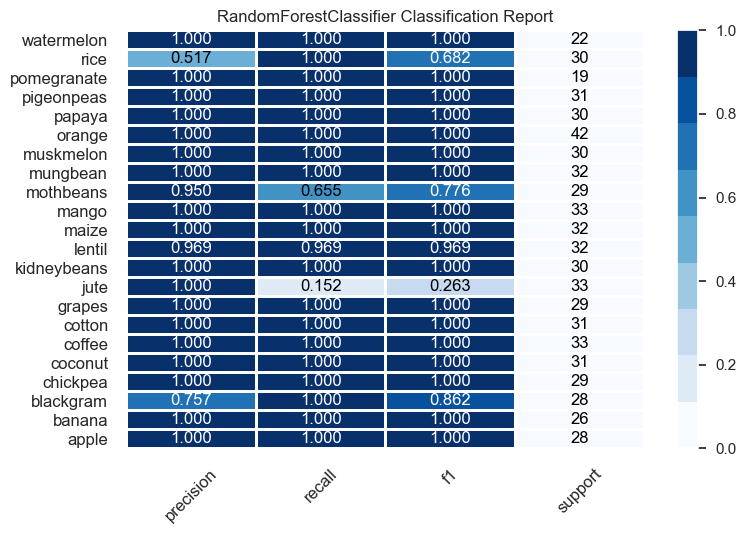

<Axes: title={'center': 'RandomForestClassifier Classification Report'}>

In [ ]:
from yellowbrick.classifier import ClassificationReport
classes=list(targets.values())
visualizer = ClassificationReport(clf, classes=classes, support=True,cmap="Blues")

visualizer.fit(X_train, y_train)  # Fit the visualizer and the model
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show()

### crop list

In [ ]:
targets

{0: 'apple',
 1: 'banana',
 2: 'blackgram',
 3: 'chickpea',
 4: 'coconut',
 5: 'coffee',
 6: 'cotton',
 7: 'grapes',
 8: 'jute',
 9: 'kidneybeans',
 10: 'lentil',
 11: 'maize',
 12: 'mango',
 13: 'mothbeans',
 14: 'mungbean',
 15: 'muskmelon',
 16: 'orange',
 17: 'papaya',
 18: 'pigeonpeas',
 19: 'pomegranate',
 20: 'rice',
 21: 'watermelon'}

## <div style="color:blue;"><b>CROP PREDICTION</b></div>
### **K / P / N / Temperature / humidity / pH / Rainfall가 중요 요소 **

### K-nn 사용

In [ ]:
data = np.array([[100, 40, 37, 25, 40, 6.9, 5]])
prediction = knn.predict(data) # knn알고리즘 적용
value = prediction[0]
targets[value]

'banana'

### Random Forest Classifier

In [ ]:
data = np.array([[75, 41, 35, 24.97042599, 78.62697699, 6.856833064, 166.64152]])
prediction = clf.predict(data) # Random Forest 알고리즘 적용
value = prediction[0]
targets[value]

'rice'